# EDA

### Imports

In [1]:
from datetime import datetime
from copy import deepcopy

import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pylab as plt

### Reading csv files

* Files located in data/ directory:
    * PPK_Participants.csv
    * PPK_Employers.csv
* After reading files we merge them into one dataframe, adding columns describing participant's employee data

In [2]:
# Reading CSV files
participants = pd.read_csv('data/PPK_Participants.csv', sep=';')
employers = pd.read_csv('data/PPK_Employers.csv', sep=';')

# Merging
df = pd.merge(
    participants,
    employers,
    how='left',
    left_on='EMPL_ID',
    right_on='ID'
)

### Processing features, cleaning up unimportant information

* Fixing the `AGE` column because of its weird format

* Containing small nationality groups into one 'other' nationality group

* Finding `DURATION` - days since participant registered for the program until resignation

In [3]:
# Age to int
def to_int(age):
    age = age[:age.find(",")]
    return int(age)

df["AGE"] = df["AGE"].apply(to_int)

In [4]:
# Grouping other nationalities into one category '0'

unique_nat = df['NATIONALITY'].unique()
for val in unique_nat:
    suma = ( df['NATIONALITY'].values == val ).sum()
    if suma < 5000:
        df.loc[df.NATIONALITY == val, 'NATIONALITY'] = 0      

In [5]:
# find duration of sign
def find_period(data):
    start, stop = data
    if type(stop) is float:
        return None
    
    start_year, start_month, start_day = map(int, start.split('-'))
    stop_year, stop_month, stop_day = map(int, stop.split('-'))
    
    days = (stop_year - start_year)*365
    days += (stop_month - start_month)*30 if stop_month > start_month else (start_month - stop_month)*30
    days += stop_day - start_day if stop_day > start_day else start_day - stop_day
    
    return days


df['DURATION'] = list(zip(df['SIGN_DATE'], df['RESIGN_DATE']))

df['DURATION'] = df['DURATION'].apply(find_period) 

## Graphing resign rate 

### Gender and nationality

We can see some interaction between gender and resign rate - men were a bit less likely to resign
Also, foreginers were less likely to resign than poles (114).


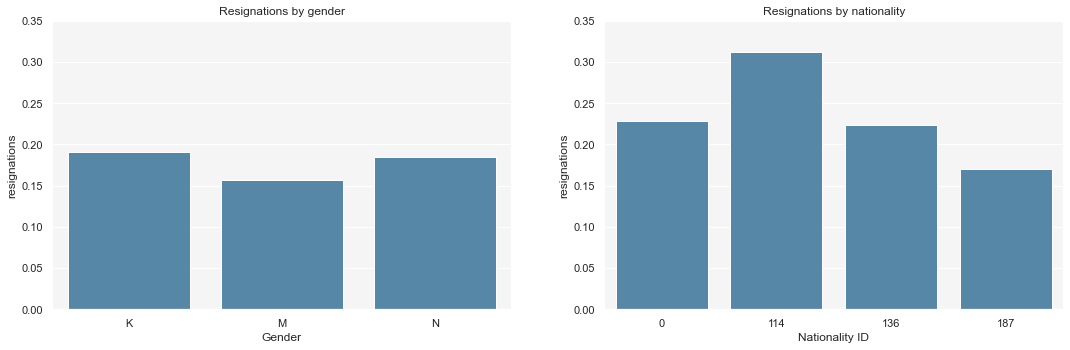

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

sns.barplot(x = df['SEX'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[0], order=["K","M","N"])
ax[0].set_facecolor('#f5f5f5')
ax[0].set_xlabel("Gender")
ax[0].set_ylabel("resignations")
ax[0].set_ylim(0,0.35)
ax[0].set_title('Resignations by gender')

sns.barplot(x = df['NATIONALITY'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[1])
ax[1].set_facecolor('#f5f5f5')
ax[1].set_ylim(0,0.35)
ax[1].set_xlabel("Nationality ID")
ax[1].set_ylabel("resignations")
ax[1].set_title('Resignations by nationality')

plt.tight_layout(pad=4.0)

### Program stage and company size

Clearly - employees of bigger companies are more likely to resign than those employed in small companies.

We can see that participants who signed during the first stage of the program are likely to have resigned. This is in part because of corelation with the company size - bigger companies were the first ones that the program was introduced in.

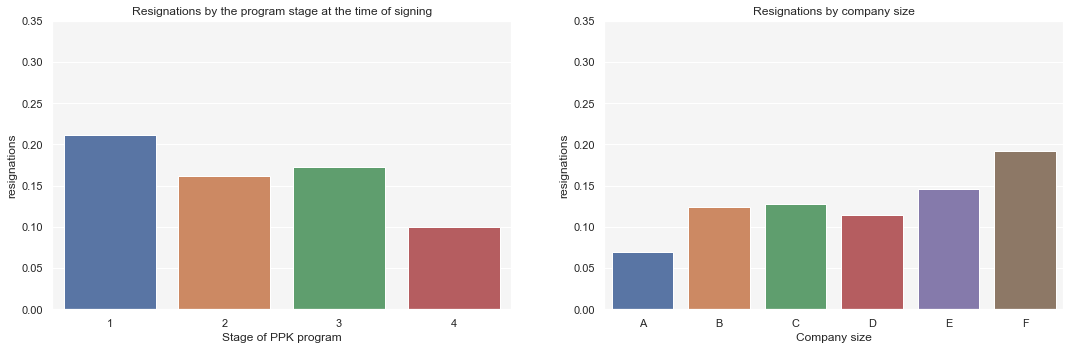

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

sns.barplot(x = df['PPK_STAGE'], y = df['IS_SUSPENDED'], ci=None, ax=ax[0])
ax[0].set_facecolor('#f5f5f5')
ax[0].set_xlabel("Stage of PPK program")
ax[0].set_ylabel("resignations")
ax[0].set_ylim(0,0.35)
ax[0].set_title('Resignations by the program stage at the time of signing')


sns.barplot(x = df['COMPANY_SIZE'], y = df['IS_SUSPENDED'], ci=None, ax=ax[1], order=["A","B","C","D","E","F"])
ax[1].set_facecolor('#f5f5f5')
ax[1].set_xlabel("Company size")
ax[1].set_ylabel("resignations")
ax[1].set_ylim(0,0.35)
ax[1].set_title("Resignations by company size")

plt.tight_layout(pad=4.0)

### Voivodeship and bank handling the account

It's hard to find a pattern here, but it seems that in fact there are banks or voivodeships with significant differences in resignation rate. There features can still be passed to the model to make sense of, but are not easy to interpretate by a human.

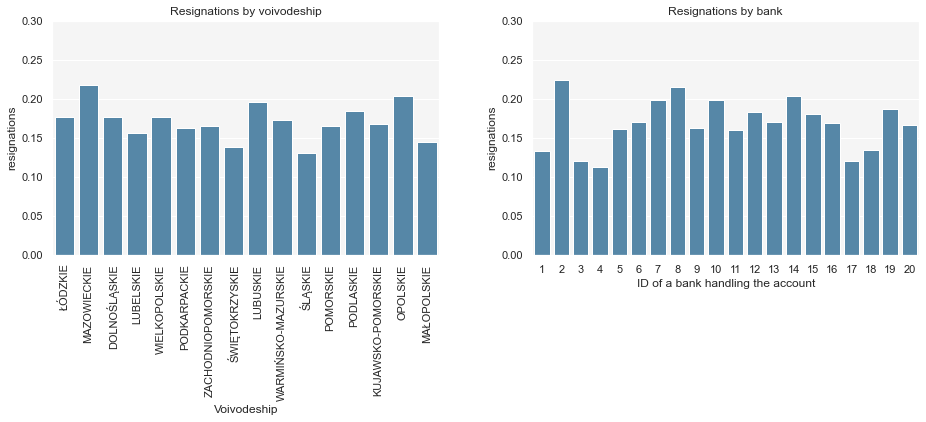

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

sns.barplot(x = df['VOIVODESHIP'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[0])
ax[0].set_facecolor('#f5f5f5')
ax[0].set_xlabel("Voivodeship")
ax[0].set_ylabel("resignations")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_ylim(0,0.3)
ax[0].set
ax[0].set_title('Resignations by voivodeship')

sns.barplot(x = df['PPK_BANK'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[1])
ax[1].set_facecolor('#f5f5f5')
ax[1].set_xlabel("ID of a bank handling the account")
ax[1].set_ylabel("resignations")
ax[1].set_ylim(0,0.3)
ax[1].set_title('Resignations by bank')

plt.tight_layout(pad=4.0)

### Age

It is easily identifiable, that people around the age of 40-50 are most likely to resign, while very young or very old people are least likely to resign. 

Text(0.5, 1.0, 'Resignation by age')

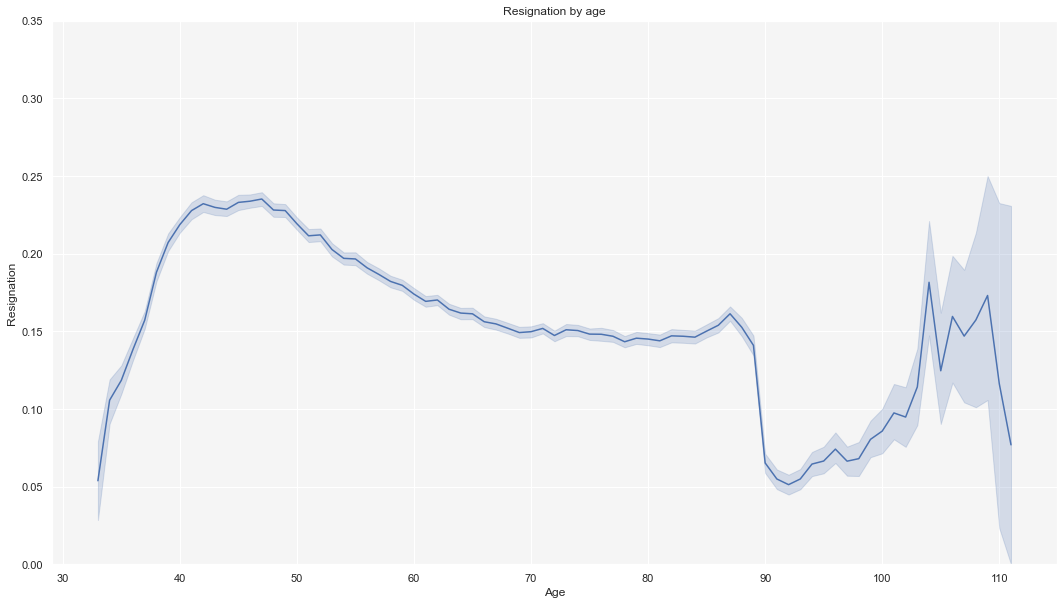

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
sns.lineplot(x = df['AGE'], y = df['IS_SUSPENDED'],ax=ax)
ax.set_facecolor('#f5f5f5')
ax.set_ylim(0,0.35)
ax.set_ylabel("Resignation")
ax.set_xlabel("Age")
ax.set_title('Resignation by age')

### Additional Payments

No wonder that someone, who decides to save more money than required is less likely to resign.

Same goes to participants with inital bonus payment from the government or those, whose employer decided to pay extra into their PPK savings account. 



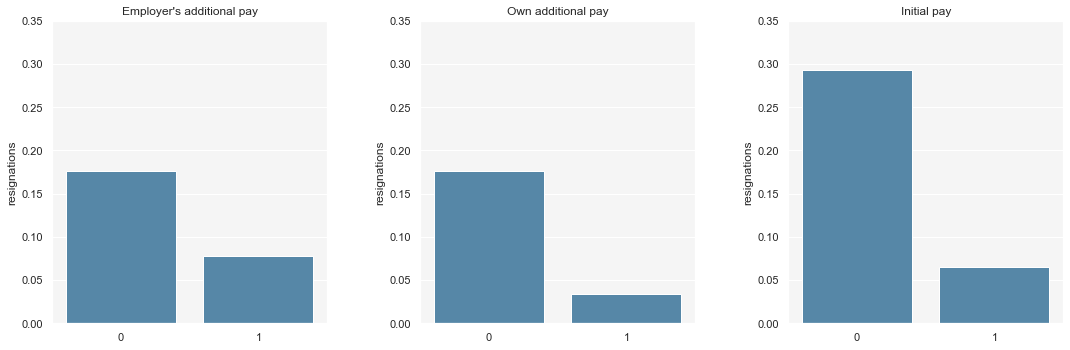

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(16,6))

# HAS\_AE - Czy pracownik otrzymuje wpłatę dodatkową od pracodawcy?
sns.barplot(x = df['HAS_AE'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[0])
ax[0].set_facecolor('#f5f5f5')
ax[0].set_xlabel(None)
ax[0].set_ylabel("resignations")
ax[0].set_ylim(0,0.35)
ax[0].set_title('Employer\'s additional pay')

# HAS\_AW - Czy pracownik wpłaca własną dodatkową wpłatę?
sns.barplot(x = df['HAS_AW'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[1])
ax[1].set_facecolor('#f5f5f5')
ax[1].set_xlabel(None)
ax[1].set_ylabel("resignations")
ax[1].set_ylim(0,0.35)
ax[1].set_title('Own additional pay')

# HAS\_IP - Czy pracownik otrzymał wpłatę powitalną?
sns.barplot(x = df['HAS_IP'], y = df['IS_SUSPENDED'], color='#488ab5', ci=None, ax=ax[2])
ax[2].set_facecolor('#f5f5f5')
ax[2].set_xlabel(None)
ax[2].set_ylabel("resignations")
ax[2].set_ylim(0,0.35)
ax[2].set_title('Initial pay')

plt.tight_layout(pad=4.0)

### Decay

We can see that most resignations take place not long from signing for the program. It can be interpreted both ways. If we were to predict who is going to resign in the near future - it would more likely be someone who recently joined the program. If the goal is to determine who of the employees in the dataset has already resigned - it would more likely be someone who joined the program long ago, simply beacause of having more time to resign.

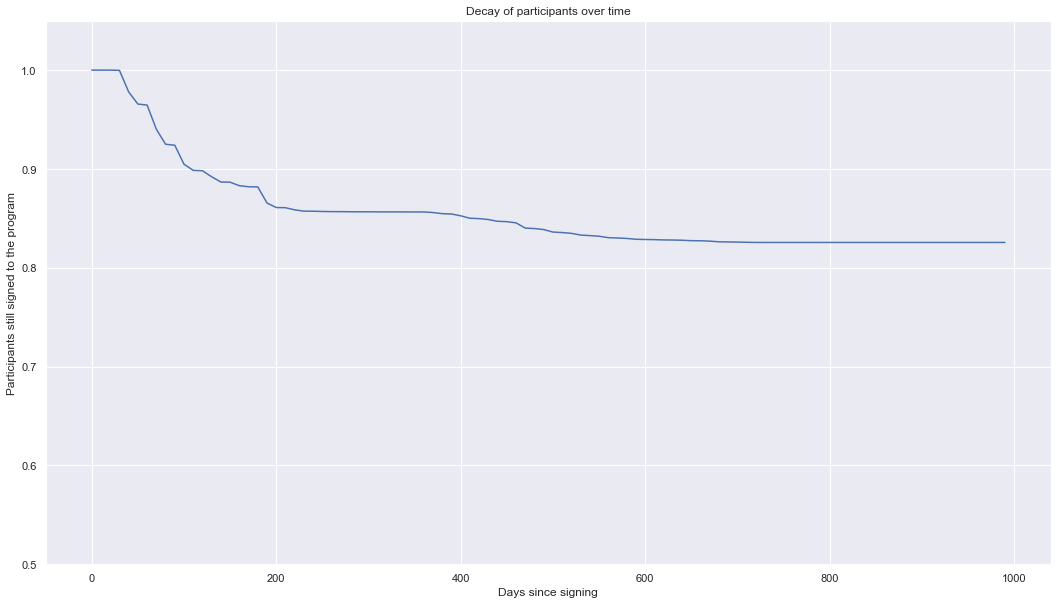

In [11]:
out = []

for i in range(0, 1000, 10):
    out.append(1-df[df["DURATION"]<i]["IS_SUSPENDED"].sum()/len(df))
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
ax.plot(np.arange(0,1000,10), out)

ax.set(xlabel='Days since signing', ylabel='Participants still signed to the program',
       title='Decay of participants over time')
plt.ylim(0.5, 1.05)

plt.show()